<a href="https://colab.research.google.com/github/Andrius-M/Sentiments/blob/main/Sentimentai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install toai

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 296kB 22.5MB/s 
     |████████████████████████████████| 122kB 23.5MB/s 
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 1.1MB 32.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 747kB 37.8MB/s 
     |████████████████████████████████| 727kB 40.1MB/s 
  Created wheel for black: filename=black-20.8b1-cp37-none-any.whl size=124184 sha256=d5f6651d75e8477c53ee9fd5937b9d0fc60f108c105ba10ddab7b06caaedae54
  Stored in directory: /root/.cache/pip/wheels/6e/10/b5/edf7359c2edd0305cce7e3f96e07daf7ce55dceac9d3ce3373
Successfully built black
  Created wheel for fastparquet: filename=fastparquet-0.5.0-cp37-cp37m-linux_x86_64.whl size=213346 sha256=7795d2069e112f54405abb1df45d0a147620f40abfb909f4c7ae60b9b9f473e5
  Stored in directory: /root/.

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from toai.imports import *

from gensim.utils import simple_preprocess
import gensim
from nltk.tokenize.treebank import TreebankWordDetokenizer
import tensorflow as tf

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

import keras

/usr/local/lib/python3.7/dist-packages/toai/imports.py:79: UserWarning: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
  warnings.warn(str(error))


In [ ]:
# How to import files and run in google colab https://www.youtube.com/watch?v=oqMImCeXi6o
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Autentification with your google account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Access file from google drive
downloaded = drive.CreateFile({'id':'1uhbnvm3-j1U8dDiTNwaqYzZxx4blMN4G'}) # replace the id with id of file you want to access
downloaded.GetContentFile('sen.xlsx') 

In [ ]:
file_name = 'sen.xlsx'
df =  pd.read_excel(file_name)

In [ ]:
df

,value,sentiment
0,neigiamas,"Gina kazkokias autoriu teises, o produkcijos n..."
1,neigiamas,"kaliningrade tai nors nera supuvusi, kaip klai..."
2,neigiamas,"ledynmetis! Šitiek turim radarų, navigacinių e..."
3,neigiamas,"Ko čia iškart minusuoji, kaip koks nevykėlis."
4,neigiamas,As tai ne iskarto minusa uzdejau. Palaukiau 10...
...,...,...
8360,teigiamas,"Stipri, sukrečianti knyga. Priverčia itin gili..."
8361,teigiamas,Negalėjau atsiplėšti. Labai patiko. Autorės vi...
8362,teigiamas,"Daug karo ,,prarytų"" paslapčių...pabėgėlių lik..."
8363,teigiamas,"Taip, kartais tikrai panašu buvo į Titaniką. Y..."


In [ ]:
df["value"].isnull().sum()

0

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)
    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)
    # Remove new line characters
    data = re.sub('\s+', ' ', data)
    # Remove distracting single quotes
    data = re.sub("\'", "", data)
    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = df['sentiment'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
#list(temp[:5])
#print(list(temp))

In [ ]:
temp

['Gina kazkokias autoriu teises, o produkcijos nera kur nusipirkti. cia atrodo geriau zmogus neturetu nieko, nei turetu parsisiuntes is linkomanijos.',
 'kaliningrade tai nors nera supuvusi, kaip klaipedoje.',
 'ledynmetis! Šitiek turim radarų, navigacinių elektroninių ir mechaninių prietaisų, satelitų, galimybes stebėti iš oro - ir še tau, laivų negalima pamatyti',
 'Ko čia iškart minusuoji, kaip koks nevykėlis.',
 'As tai ne iskarto minusa uzdejau. Palaukiau 10sek.',
 'Uzzombintiems sistemos vergams info',
 'ar atiduosi Windows Mobile source i opensource? Nors viena karta neapsik developeriu!!',
 'Kas matėt dirbanti žydą, o šitas nusikaltėlis dar kitus moko.',
 'Bilas = provakseris bet savo vaiku neskiepija.. Kodel? Nes zino ka parduoda! Ar tai biznis/verslas?',
 'Daug kas investuoja i issilavima ir ziauriai daug laimi, NET 50 eur kokiu daugiau gal 100 jei pasiseka. Magistras koks gauna 600 ar 700, vietoj 550, ot tai paguoda didele ;) o kai kurie ir be issilavinimo daugiau gauna, sta

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True, min_len=2))  # deacc=True removes punctuations
        #return gensim.utils.simple_preprocess(str(sentence), deacc=True)  
        
data_words = list(sent_to_words(temp))

print(data_words[:10])
#print(data_words)

[['gina', 'kazkokias', 'autoriu', 'teises', 'produkcijos', 'nera', 'kur', 'nusipirkti', 'cia', 'atrodo', 'geriau', 'zmogus', 'neturetu', 'nieko', 'nei', 'turetu', 'parsisiuntes', 'is', 'linkomanijos'], ['kaliningrade', 'tai', 'nors', 'nera', 'supuvusi', 'kaip', 'klaipedoje'], ['ledynmetis', 'sitiek', 'turim', 'radaru', 'navigaciniu', 'elektroniniu', 'ir', 'mechaniniu', 'prietaisu', 'satelitu', 'galimybes', 'stebeti', 'is', 'oro', 'ir', 'se', 'tau', 'laivu', 'negalima', 'pamatyti'], ['ko', 'cia', 'iskart', 'minusuoji', 'kaip', 'koks', 'nevykelis'], ['as', 'tai', 'ne', 'iskarto', 'minusa', 'uzdejau', 'palaukiau', 'sek'], ['uzzombintiems', 'sistemos', 'vergams', 'info'], ['ar', 'atiduosi', 'windows', 'mobile', 'source', 'opensource', 'nors', 'viena', 'karta', 'neapsik', 'developeriu'], ['kas', 'matet', 'dirbanti', 'zyda', 'sitas', 'nusikaltelis', 'dar', 'kitus', 'moko'], ['bilas', 'provakseris', 'bet', 'savo', 'vaiku', 'neskiepija', 'kodel', 'nes', 'zino', 'ka', 'parduoda', 'ar', 'tai', '

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:50])

['gina kazkokias autoriu teises produkcijos nera kur nusipirkti cia atrodo geriau zmogus neturetu nieko nei turetu parsisiuntes is linkomanijos', 'kaliningrade tai nors nera supuvusi kaip klaipedoje', 'ledynmetis sitiek turim radaru navigaciniu elektroniniu ir mechaniniu prietaisu satelitu galimybes stebeti is oro ir se tau laivu negalima pamatyti', 'ko cia iskart minusuoji kaip koks nevykelis', 'as tai ne iskarto minusa uzdejau palaukiau sek', 'uzzombintiems sistemos vergams info', 'ar atiduosi windows mobile source opensource nors viena karta neapsik developeriu', 'kas matet dirbanti zyda sitas nusikaltelis dar kitus moko', 'bilas provakseris bet savo vaiku neskiepija kodel nes zino ka parduoda ar tai biznis verslas', 'daug kas investuoja issilavima ir ziauriai daug laimi net eur kokiu daugiau gal jei pasiseka magistras koks gauna ar vietoj ot tai paguoda didele kai kurie ir be issilavinimo daugiau gauna statybose kokiose pagalbiniai buna gauna kai tuo tarpu tas magistras tiek pat ta

In [ ]:
data

In [ ]:
data = np.array(data)

In [ ]:
data

In [ ]:
labels = np.array(df['value'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutralus':
        y.append(0)
    if labels[i] == 'neigiamas':
        y.append(1)
    if labels[i] == 'teigiamas':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
#del y

In [ ]:
len(labels)

8365

In [ ]:
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
y

array([1, 1, 1, ..., 2, 2, 2])

# Data sequencing and splitting

In [ ]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   43  182    4]
 [   0    0    0 ...   50    5 1390]
 [   0    0    0 ... 3579  639  747]
 ...
 [   0    0    0 ... 1719  104   17]
 [   0    0    0 ...  118 2196  269]
 [   0    0    0 ...   17    8   72]]


In [ ]:
tweets.shape

(8365, 200)

In [ ]:
print(labels)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

6273 2092 6273 2092


# Model building

## SimpleRNN model (Bonus)

In [ ]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))


model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
197/197 [==============================] - 31s 138ms/step - loss: 1.0686 - accuracy: 0.4098 - val_loss: 0.9931 - val_accuracy: 0.4775

Epoch 00001: val_accuracy improved from -inf to 0.47753, saving model to best_model0.hdf5
Epoch 2/5
197/197 [==============================] - 27s 140ms/step - loss: 0.8732 - accuracy: 0.6106 - val_loss: 0.8481 - val_accuracy: 0.5875

Epoch 00002: val_accuracy improved from 0.47753 to 0.58748, saving model to best_model0.hdf5
Epoch 3/5
197/197 [==============================] - 27s 138ms/step - loss: 0.7234 - accuracy: 0.6800 - val_loss: 0.8510 - val_accuracy: 0.5860

Epoch 00003: val_accuracy did not improve from 0.58748
Epoch 4/5
197/197 [==============================] - 27s 137ms/step - loss: 0.5855 - accuracy: 0.7709 - val_loss: 0.8020 - val_accuracy: 0.6276

Epoch 00004: val_accuracy improved from 0.58748 to 0.62763, saving model to best_model0.hdf5
Epoch 5/5
197/197 [==============================] - 27s 137ms/step - loss: 0.4835 - accu

## Single LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/70
197/197 [==============================] - 32s 13ms/step - loss: 1.0723 - accuracy: 0.4106 - val_loss: 0.9887 - val_accuracy: 0.5005

Epoch 00001: val_accuracy improved from -inf to 0.50048, saving model to best_model1.hdf5
Epoch 2/70
197/197 [==============================] - 2s 11ms/step - loss: 0.9254 - accuracy: 0.5590 - val_loss: 0.8738 - val_accuracy: 0.5903

Epoch 00002: val_accuracy improved from 0.50048 to 0.59034, saving model to best_model1.hdf5
Epoch 3/70
197/197 [==============================] - 2s 11ms/step - loss: 0.8021 - accuracy: 0.6226 - val_loss: 0.8344 - val_accuracy: 0.6128

Epoch 00003: val_accuracy improved from 0.59034 to 0.61281, saving model to best_model1.hdf5
Epoch 4/70
197/197 [==============================] - 2s 11ms/step - loss: 0.7345 - accuracy: 0.6676 - val_loss: 0.8174 - val_accuracy: 0.6291

Epoch 00004: val_accuracy improved from 0.61281 to 0.62906, saving model to best_model1.hdf5
Epoch 5/70
197/197 [==============================] - 

## Bidirectional LTSM model

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/70
197/197 [==============================] - 8s 23ms/step - loss: 1.0594 - accuracy: 0.4180 - val_loss: 0.8972 - val_accuracy: 0.5832

Epoch 00001: val_accuracy improved from -inf to 0.58317, saving model to best_model2.hdf5
Epoch 2/70
197/197 [==============================] - 4s 19ms/step - loss: 0.8444 - accuracy: 0.6004 - val_loss: 0.8427 - val_accuracy: 0.5908

Epoch 00002: val_accuracy improved from 0.58317 to 0.59082, saving model to best_model2.hdf5
Epoch 3/70
197/197 [==============================] - 4s 19ms/step - loss: 0.7555 - accuracy: 0.6408 - val_loss: 0.8308 - val_accuracy: 0.5870

Epoch 00003: val_accuracy did not improve from 0.59082
Epoch 4/70
197/197 [==============================] - 4s 19ms/step - loss: 0.7028 - accuracy: 0.6815 - val_loss: 0.8417 - val_accuracy: 0.5856

Epoch 00004: val_accuracy did not improve from 0.59082
Epoch 5/70
197/197 [==============================] - 4s 19ms/step - loss: 0.6381 - accuracy: 0.7187 - val_loss: 0.7699 - val_accur


## 1D Convolutional model

In [ ]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=70,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/70
197/197 [==============================] - 3s 8ms/step - loss: 1.5902 - acc: 0.3971 - val_loss: 1.1006 - val_acc: 0.3924
Epoch 2/70
197/197 [==============================] - 1s 6ms/step - loss: 1.0962 - acc: 0.3920 - val_loss: 1.0942 - val_acc: 0.3924
Epoch 3/70
197/197 [==============================] - 1s 6ms/step - loss: 1.0910 - acc: 0.3990 - val_loss: 1.0928 - val_acc: 0.4446
Epoch 4/70
197/197 [==============================] - 1s 6ms/step - loss: 1.0851 - acc: 0.4181 - val_loss: 1.0869 - val_acc: 0.4431
Epoch 5/70
197/197 [==============================] - 1s 6ms/step - loss: 1.0835 - acc: 0.4419 - val_loss: 1.0861 - val_acc: 0.4407
Epoch 6/70
197/197 [==============================] - 1s 7ms/step - loss: 1.0742 - acc: 0.4519 - val_loss: 1.0770 - val_acc: 0.4460
Epoch 7/70
197/197 [==============================] - 1s 6ms/step - loss: 1.0539 - acc: 0.4731 - val_loss: 1.0663 - val_acc: 0.4551
Epoch 8/70
197/197 [==============================] - 1s 6ms/step - loss: 1.

# Best model validation

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

66/66 - 1s - loss: 0.9412 - accuracy: 0.6640
Model accuracy:  0.663957953453064


In [ ]:
predictions = best_model.predict(X_test)


# Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


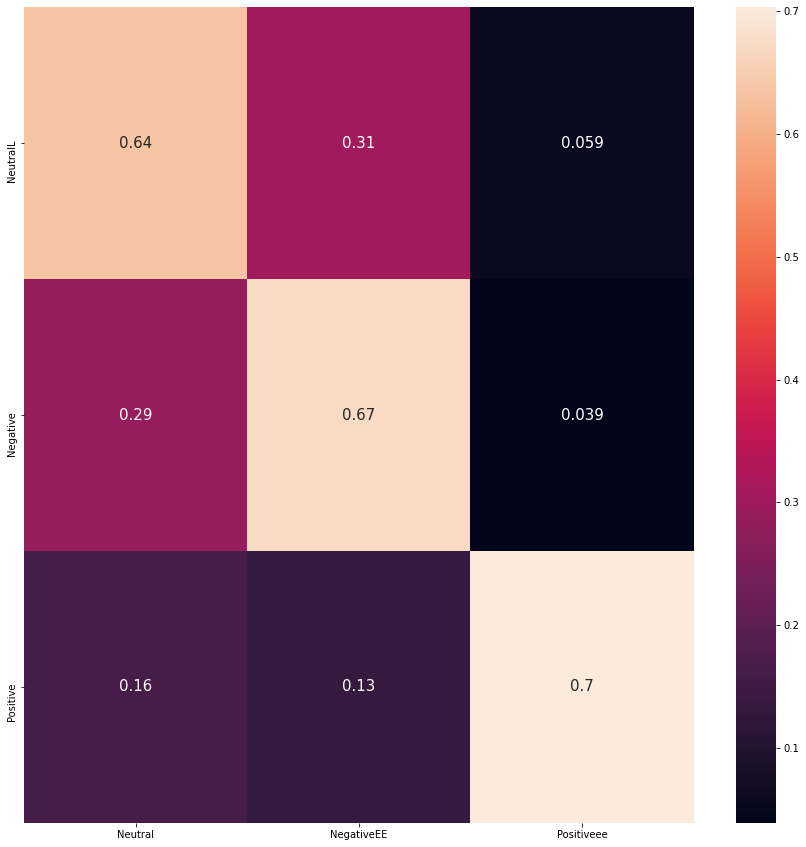

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['NeutralL','Negative','Positive'],columns = ['Neutral','NegativeEE','Positiveee'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['kokia nuostabi diena.. '])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

'Positive'